In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import datetime
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from math import *

train = pd.read_csv('data_train.csv')
test = pd.read_csv('data_test.csv')
train = train.drop(['Unnamed: 0'],axis=1)
test = test.drop(['Unnamed: 0'],axis=1)

tr = test.loc[test.x_exit.isnull()]

def conv(time_1):   
    sec1 = 3600*int(time_1[0:2]) + 60*int(time_1[3:5]) + int(time_1[6:8])                                                                                                                                
    return (sec1)

# vec_conv =  np.vectorize(conv)
# train.time_entry=vec_conv(train.time_entry)
# train.time_exit=vec_conv(train.time_exit)

#incohérences
train['vmean'][(train.time_entry==train.time_exit)] = 0
train['vmin'][(train.time_entry==train.time_exit)] = 0
train['vmax'][(train.time_entry==train.time_exit)] = 0

test['vmean'][(test.time_entry==test.time_exit)] = 0
test['vmin'][(test.time_entry==test.time_exit)] = 0
test['vmax'][(test.time_entry==test.time_exit)] = 0

train['vmax'][(train.x_entry==train.x_exit)&(train.y_entry==train.y_exit)] = 0
train['vmin'][(train.x_entry==train.x_exit)&(train.y_entry==train.y_exit)] = 0
train['vmean'][(train.x_entry==train.x_exit)&(train.y_entry==train.y_exit)] = 0

test['vmax'][(test.x_entry==test.x_exit)&(test.y_entry==test.y_exit)] = 0
test['vmin'][(test.x_entry==test.x_exit)&(test.y_entry==test.y_exit)] = 0
test['vmean'][(test.x_entry==test.x_exit)&(test.y_entry==test.y_exit)] = 0

#outliers
train.vmean = train.vmean.loc[(train.vmean<90) & (train.vmean>=0)]
train.vmax = train.vmean.loc[(train.vmax<90) & (train.vmax>=0)]
train.vmin = train.vmean.loc[(train.vmin<90) & (train.vmin>=0)]

#nan by mean
train['vmax']=train['vmax'].replace( np.NaN , train['vmax'].mean() )
train['vmin']=train['vmin'].replace( np.NaN , train['vmin'].mean() )
train['vmean']=train['vmean'].replace( np.NaN , train['vmean'].mean() )

test['vmax']=test['vmax'].replace( np.NaN , test['vmax'].mean() )
test['vmin']=test['vmin'].replace( np.NaN , test['vmin'].mean() )
test['vmean']=test['vmean'].replace( np.NaN , test['vmean'].mean() )

# trainTempVmean = train.loc[(train.vmean>0)]
# trainTempVmean = trainTempVmean.dropna()
# trainTempVmean = trainTempVmean.vmean.mean()

# trainTempVmax = train.loc[(train.vmax>0)]
# trainTempVmax = trainTempVmax.dropna()
# trainTempVmax = trainTempVmax.vmax.mean()

# trainTempVmin = train.loc[(train.vmin>0)]
# trainTempVmin = trainTempVmin.dropna()
# trainTempVmin = trainTempVmin.vmin.mean()

# testTempVmean = test.loc[(test.vmean>0)]
# testTempVmean = testTempVmean.dropna()
# testTempVmean = testTempVmean.vmean.mean()

# testTempVmax = test.loc[(test.vmax>0)]
# testTempVmax = testTempVmax.dropna()
# testTempVmax = testTempVmax.vmax.mean()

# testTempVmin = test.loc[(test.vmin>0)]
# testTempVmin = testTempVmin.dropna()
# testTempVmin = testTempVmin.vmin.mean()


# train['vmax']=train['vmax'].replace( np.NaN , trainTempVmax)
# train['vmin']=train['vmin'].replace( np.NaN , trainTempVmin)
# train['vmean']=train['vmean'].replace( np.NaN , trainTempVmean)
# test['vmax']=test['vmax'].replace( np.NaN , testTempVmax)
# test['vmin']=test['vmin'].replace( np.NaN , testTempVmin)
# test['vmean']=test['vmean'].replace( np.NaN , testTempVmean)

vec_conv =  np.vectorize(conv)
train.time_entry=vec_conv(train.time_entry)
train.time_exit=vec_conv(train.time_exit)

test.time_entry=vec_conv(test.time_entry)
test.time_exit=vec_conv(test.time_exit)

C:\Users\gouzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gouzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gouzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gouzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [2]:
train['city_center'] = 0
train['city_center'][(train.x_exit>=3750901.5068) & (train.x_exit<=3770901.5068)&(train.y_exit>=(-19268905.6133)) & (train.y_exit<=(-19208905.6133))]=1

C:\Users\gouzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [3]:
Y=train
Y = Y.groupby('hash')['city_center'].apply(list)
for i in range (Y.shape[0]):
    Y[i]=Y[i][-1]

Y=pd.DataFrame(Y)
Y = pd.DataFrame(Y.values)

In [4]:
train = train.drop(['city_center'],axis=1)
train = train.drop(['trajectory_id'],axis=1)
test = test.drop(['trajectory_id'],axis=1)

def transformOnLine(df,):
    lesdataframes=[]

    for vincent in df.columns[1:]:
        print(vincent)
        k=df
        k = k.groupby('hash')[vincent].apply(list)

        if (vincent == 'x_exit') | (vincent == 'y_exit'):
            for i in range (k.shape[0]):
                k[i].reverse()
                k[i]=k[i][1:]      #x_exit y_exit
        else :
            for i in range (k.shape[0]):
                k[i].reverse()


        k=pd.DataFrame(k)


        # expand df.time_entry into its own dataframe
        gouz = k[vincent].apply(pd.Series)

        # rename each variable is time_entry
        gouz = gouz.rename(columns = lambda x : 'tag_' + str(x))
        gouz = gouz.fillna(0)
        lesdataframes.append(gouz)

    r = pd.concat(lesdataframes,axis=1)
    r = r.reset_index()
    r = r.drop(['hash'],axis=1)
    r.columns = np.arange(len(r.columns))
    return r

In [5]:
X = transformOnLine(train)
X_test = transformOnLine(test)

time_entry
time_exit
vmax
vmin
vmean
x_entry
y_entry
x_exit
y_exit
time_entry
time_exit
vmax
vmin
vmean
x_entry
y_entry
x_exit
y_exit


In [273]:

# #calculs des angles

# #X[14] X[15] x et y entry
# #X[16] X[17] x et y exit
# #(3750901.5068+3770901.5068)/2 x centre
# # = 3760901.5068
# #(-19268905.6133+-19208905.6133)/2
# # = -19238905.6133

# u = np.array([X[16],X[17]])-np.array([X[14],X[15]])
# v = np.array([3760901.5068-X[14],-19238905.6133-X[15]])

# angle_train = []
# for i in range(u.shape[1]):
#     scalar = (np.dot([u[0][i],u[1][i]],[v[0][i],v[1][i]]))
#     u_norm = (np.linalg.norm([u[0][i],u[1][i]]))
#     v_norm = (np.linalg.norm([v[0][i],v[1][i]]))
#     angle_train.append(degrees(acos(scalar/(u_norm*v_norm))))
    
# u = np.array([X_test[16],X_test[17]])-np.array([X_test[14],X_test[15]])
# v = np.array([3760901.5068-X_test[14],-19238905.6133-X_test[15]])

# angle_test = []
# for i in range(u.shape[1]):
#     scalar = (np.dot([u[0][i],u[1][i]],[v[0][i],v[1][i]]))
#     u_norm = (np.linalg.norm([u[0][i],u[1][i]]))
#     v_norm = (np.linalg.norm([v[0][i],v[1][i]]))
#     angle_test.append(degrees(acos(scalar/(u_norm*v_norm))))

# #application

# X['angle']=angle_train
# X_test['angle']=angle_test

In [222]:
# import time
# print(datetime.datetime.now())
# X = X
# y = Y
# param_grid = {
#     'num_boost_round': [50,70,100],
#     'eta': [0.2,0.1],
#     'max_depth': [8,10],
#     'min_child_weight': [0.25,0.5,1],
#     'n_jobs':[-1]
# }

# i=1
# kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)

# for train_index,test_index in kf.split(X,y):
#     print('\n{} of kfold {}'.format(i,kf.n_splits))
#     print(datetime.datetime.now())
#     xtr,xvl = X.loc[train_index],X.loc[test_index]
#     ytr,yvl = y[train_index],y[test_index]
#     model = GridSearchCV(XGBClassifier(), param_grid, cv=5, scoring= 'f1',iid=True)
#     print ('-------')
#     model.fit(xtr, ytr)
#     print (model.best_params_)
#     pred=model.predict(xvl)
#     print('f1score',f1_score(yvl,pred))
#     i+=1
    

# print('----------')
# print(datetime.datetime.now())

2019-04-19 01:08:50.621153

1 of kfold 5
2019-04-19 01:08:50.668196
-------
{'eta': 0.2, 'max_depth': 10, 'min_child_weight': 0.5, 'n_jobs': -1, 'num_boost_round': 50}


NameError: name 'f1_score' is not defined

In [ ]:
#model = pickle.load(open('XGB_best.pickle', 'rb'))
pickle.dump(model,open('XGB_best_2','wb'))

In [57]:
pred = model.best_estimator_.predict(X_test)
prediction = pd.DataFrame()

In [9]:
trajectory_id = tr['trajectory_id']

In [10]:
trajectory_id=trajectory_id.values
prediction['id']=trajectory_id
prediction['target']=pred

In [11]:
prediction.target = prediction.target.astype(int)
prediction.describe()

,target
count,33515.000000
mean,0.280829
std,0.449411
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [13]:
prediction.to_csv("OL_XGB_default.csv",index=False)

In [ ]:
print(model.best_params_)

In [12]:
prediction.target.value_counts()

0    24103
1     9412
Name: target, dtype: int64

In [6]:
clf = XGBClassifier()

In [7]:
clf.fit(X,Y)

C:\Users\gouzm\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gouzm\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [8]:
pred = clf.predict(X_test)
prediction = pd.DataFrame()

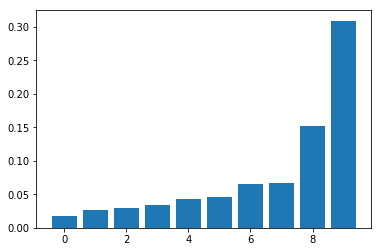

array([123, 103,  60, 101,  40, 122, 121, 102, 100, 120], dtype=int64)

In [356]:
from matplotlib import pyplot
pyplot.bar(range(len(clf.feature_importances_[np.argsort(clf.feature_importances_)[-10:]])), clf.feature_importances_[np.argsort(clf.feature_importances_)[-10:]])
pyplot.show()
np.argsort(clf.feature_importances_)[-10:]

In [76]:
import tensorflow as tf
import theano # utilise à la fois le Cpu et le Gpu de l'ordinateur
import keras
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X1=scaler.fit_transform(X)
X1_test=scaler.transform(X_test)

C:\Users\gouzm\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\gouzm\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\gouzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [85]:
def Build_Classif ():
    classifier = Sequential()
    classifier.add(Dense(units=89,activation="relu",kernel_initializer="uniform",input_dim=178)) #1ere couche
    classifier.add(Dense(units=89,activation="relu",kernel_initializer="uniform")) #couche cachée
    classifier.add(Dense(units=1,activation="sigmoid",kernel_initializer="uniform")) #to get a proba
    classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
    return classifier

In [ ]:
classifier = KerasClassifier(build_fn=Build_Classif,batch_size=, epochs=30)